In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def _load_nii_as_ras(path):
    nii = nib.load(path)
    nii = nib.as_closest_canonical(nii)  # reorienta a RAS
    data = nii.get_fdata()
    print("data:",data.shape)
    return data

def _auto_x_from_mask(mask):
    # devuelve el índice X centrado en el bbox donde hay máscara
    vox = np.argwhere(mask > 0)
    if vox.size == 0:
        # si la máscara está vacía, usa el centro del volumen
        return mask.shape[0] // 2
    x_min, x_max = vox[:, 0].min(), vox[:, 0].max()
    return int((x_min + x_max) / 2)

def _normalize_img(img, pmin=1, pmax=99):
    lo, hi = np.percentile(img, [pmin, pmax])
    if hi <= lo:
        return img
    img = np.clip(img, lo, hi)
    img = (img - lo) / (hi - lo + 1e-8)
    return img

def plot_x_slice(image_path, mask_path, x=None, class_id=None, figsize=(12,4), save_path=None,axis="x"):
    """
    image_path: ruta a NIfTI de imagen
    mask_path:  ruta a NIfTI de máscara (entera; valores {0,1,2,...})
    x: índice sobre el eje X (sagital). Si None -> auto a partir de la máscara
    class_id: si se especifica, muestra sólo esa clase en la máscara; si None usa todo >0
    """
    img  = _load_nii_as_ras(image_path)   # shape (X, Y, Z)
    print("img:",img.min(),img.max(),img.std())
    mask = _load_nii_as_ras(mask_path)    # shape (X, Y, Z)


    if img.ndim == 3:
        if axis == "z":
            img = img
            mask = mask if mask is None else mask
        elif axis == "y":
            #print("swap y")
            img = np.swapaxes(img, 0, 1)  # (H,D,W)
            mask = None if mask is None else np.swapaxes(mask,0,1)
        else:  # axis == "x"
            #print("swap x")
            img = np.swapaxes(img, 0, 2)  # (W,H,D)
            mask = None if mask is None else np.swapaxes(mask,0,2)
    else:
        raise ValueError("img debe ser 3D")

    # aseguramos tipos
    img  = img.astype(np.float32)
    mask = mask.astype(np.int16)

    if x is None:
        x = _auto_x_from_mask(mask)

    # recortes sagitales
    img_x  = img[x, :, :].T   # .T para que se vea (Y,Z) con Z vertical (opcional)
    msk_x  = mask[x, :, :].T

    # si hay class_id, filtramos; si no, todo >0
    if class_id is not None:
        msk_bin = (msk_x == class_id).astype(np.uint8)
    else:
        msk_bin = (msk_x > 0).astype(np.uint8)

    img_x_n = _normalize_img(img_x)

    # colormap para la máscara (binaria): transparente + color
    # si tu máscara tiene múltiples clases y quieres colorearlas, adapta este cmap.
    cmap_mask = ListedColormap([
        (0,0,0,0.0),   # fondo transparente
        (1,0,0,0.6),   # clase en rojo semitransparente
    ])

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    ax = axes[0]
    im0 = ax.imshow(img_x_n, cmap='gray', origin='lower')
    ax.set_title(f'Imagen (X={x})')
    ax.axis('off')

    ax = axes[1]
    # para visualizar la máscara original (si multiclase)
    if class_id is None and msk_x.max() > 1:
        # mapa categórico simple: 0 transparente, 1 verde, 2 cian, 3 magenta, etc.
        base_colors = [(0,0,0,0.0), (0,1,0,1.0), (0,1,1,1.0), (1,0,1,1.0), (1,1,0,1.0)]
        # extiende si hace falta
        k = int(msk_x.max())
        if k+1 > len(base_colors):
            extra = [(1,0,0,1.0)] * (k+1-len(base_colors))
            cmap_full = ListedColormap(base_colors + extra)
        else:
            cmap_full = ListedColormap(base_colors[:k+1])
        ax.imshow(msk_x, cmap=cmap_full, origin='lower', interpolation='nearest')
        ax.set_title('Máscara (multiclase)')
    else:
        ax.imshow(msk_bin, cmap=ListedColormap([(0,0,0,0.0),(0,1,0,1.0)]),
                  origin='lower', interpolation='nearest')
        ax.set_title('Máscara (binaria)')
    ax.axis('off')

    ax = axes[2]
    ax.imshow(img_x_n, cmap='gray', origin='lower')
    ax.imshow(msk_bin, cmap=cmap_mask, origin='lower', interpolation='nearest')
    ax.set_title('Overlap')
    ax.axis('off')

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()



data: (197, 233, 189)
img: -0.5225913524627686 16.108598709106445 1.6950123750524684
data: (197, 233, 189)


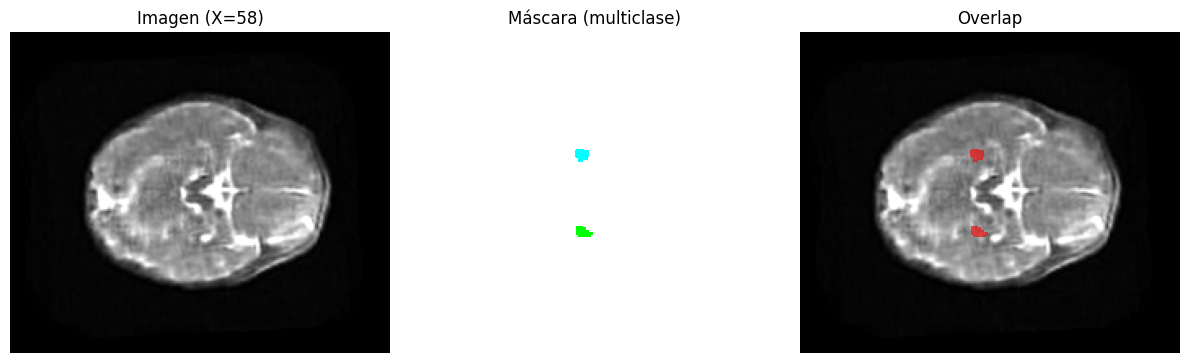

data: (197, 233, 189)
img: -0.5225913524627686 16.108598709106445 1.6950123750524684
data: (197, 233, 189)


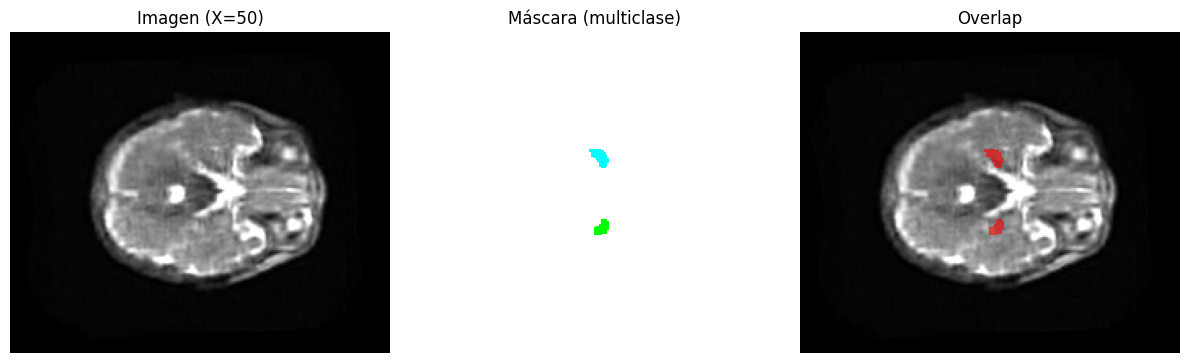

data: (197, 233, 189)
img: -0.5225913524627686 16.108598709106445 1.6950123750524684
data: (197, 233, 189)


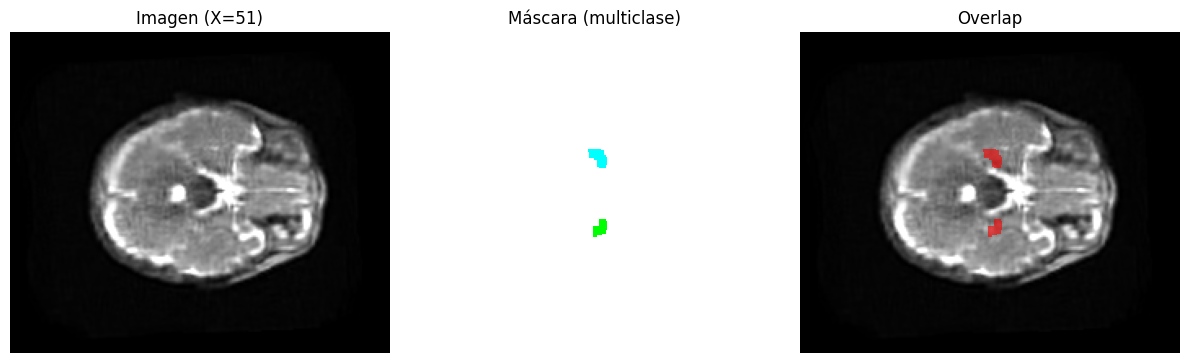

data: (197, 233, 189)
img: -0.5225913524627686 16.108598709106445 1.6950123750524684
data: (197, 233, 189)


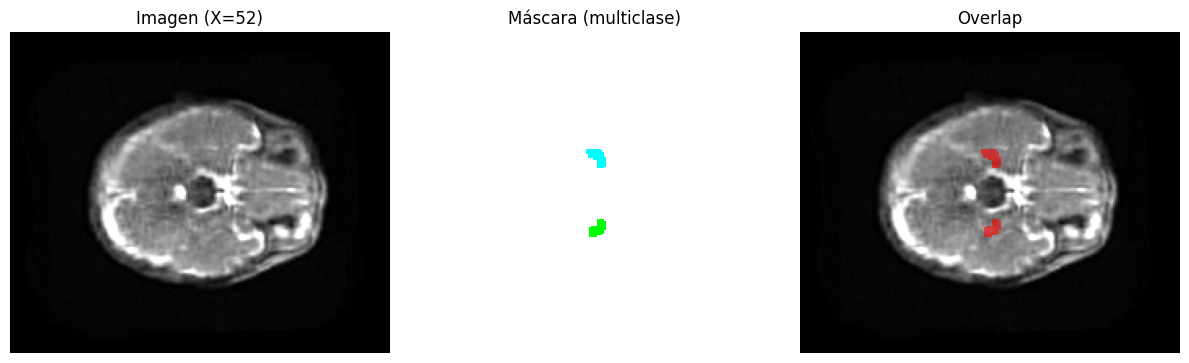

data: (197, 233, 189)
img: -0.5225913524627686 16.108598709106445 1.6950123750524684
data: (197, 233, 189)


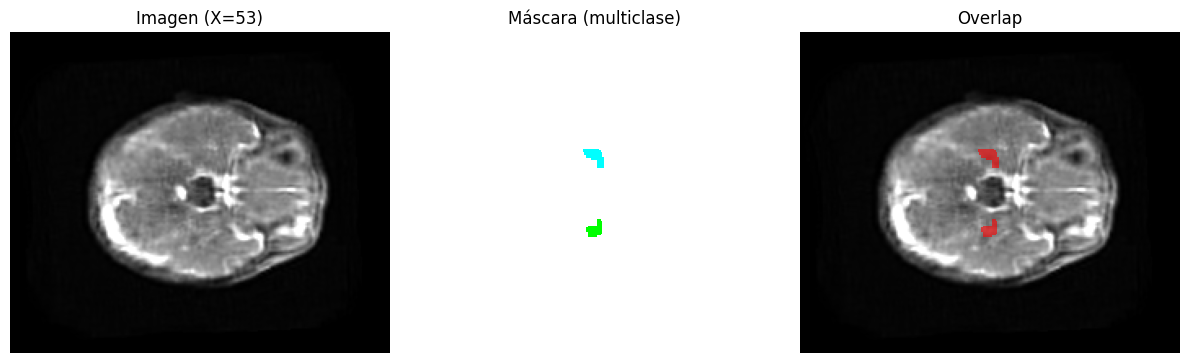

data: (197, 233, 189)
img: -0.5225913524627686 16.108598709106445 1.6950123750524684
data: (197, 233, 189)


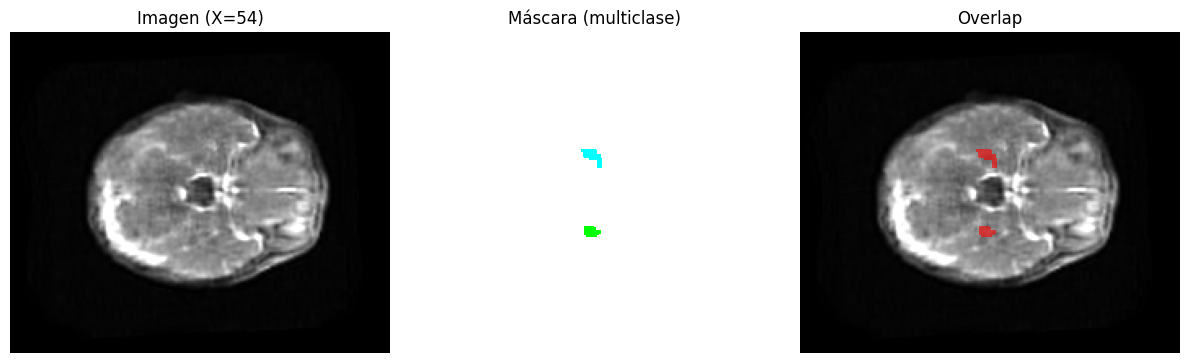

data: (197, 233, 189)
img: -0.5225913524627686 16.108598709106445 1.6950123750524684
data: (197, 233, 189)


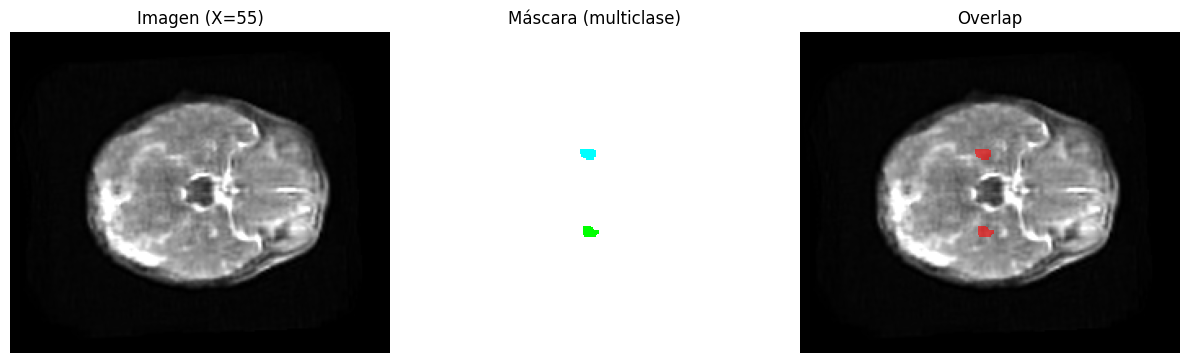

In [2]:
# ===== Ejemplo de uso con tus rutas =====
image_path = "/data/cristian/projects/med_data/rise-miccai/task-2/735/155885735/LISA_0001_ciso.nii.gz"
mask_path  = "/data/cristian/projects/med_data/rise-miccai/task-2/960/155887960/LISA_0001_HF_hipp.nii.gz"

# Slice automático donde haya máscara:
plot_x_slice(image_path, mask_path, x=None)         

# O escoger una clase específica (por ejemplo, clase=1):
#plot_x_slice(image_path, mask_path, x=None, class_id=1)

# O forzar un índice X concreto:
for x in range(50,56):
  plot_x_slice(image_path, mask_path, x=x)
